In [187]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
class instrument:
    cash_flows=0
    
    def PV(self):
        return(0)

In [341]:
def delta(t1,t2):
    return((t2-t1).days/360)

class DISC_Curve:
    def __init__(self,_spot_date,_zeros,_mat):
        self.spot_date=_spot_date
        self.zeros=_zeros
        self.mat=_mat
        self.tenors= [delta(spot_date,i) for i in _mat]
        self.libors=[((1/pv)-1)/t for (pv,t) in zip(_zeros,self.tenors)]
        
    def get_zero(self,maturity):
        t=delta(self.spot_date,maturity)
        l=np.interp(t,self.tenors,self.libors)
        return(1/(1+l*t))
    
    def set_node(self,zero, mat_date):
        self.zeros.append(zero)
        self.mat.append(mat_date)
        tenor=delta(self.spot_date,mat_date)
        self.tenors.append(tenor)
        self.libors.append(((1/zero)-1)/tenor)
        

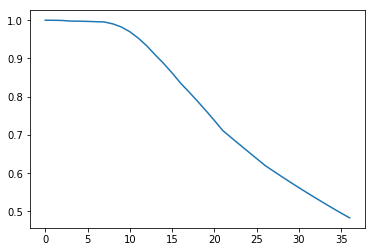

In [467]:
mkt_data=pd.read_csv('C:/Users/claud/OneDrive/Escritorio/prueba.csv')
pmts=pd.read_csv('C:/Users/claud/OneDrive/Escritorio/pagos instrumentos.csv')
spot_date=pd.to_datetime('03/10/2012',format='%d/%m/%Y')
mkt_data['Maturity Dates']=pd.to_datetime(mkt_data['Maturity Dates'],format='%d/%m/%Y')
pmts.Tenor=pd.to_datetime(pmts.Tenor,format='%d/%m/%Y')

#last_swp_date=list(mkt_data.iloc[-1:,0])[0]
#mkt_data['Maturity Dates']=mkt_data['Maturity Dates'].apply(lambda x: x-spot_date)

LIBORS=mkt_data.loc[mkt_data.Source=="LIBOR"]
FUTURES=mkt_data.loc[mkt_data.Source=="Futures"]
SWAPS=mkt_data.loc[mkt_data.Source=="Swap"]

MAT=[i for i in LIBORS['Maturity Dates']]
DF=[1/(1+delta(spot_date,i)*j/100) for (i,j) in zip(LIBORS['Maturity Dates'],LIBORS['Market Quotes'])]

disc_factor=DISC_Curve(spot_date,DF,MAT)

S=list(pmts.Tenor.loc[pmts.Instrument=='FUT'])

for i in range(len(reset_dates_fut)-1):
    t=delta(S[i],S[i+1])
    df=disc_factor.get_zero(S[i])/(1+(1-list(FUTURES['Market Quotes'])[i]/100)*t)
    disc_factor.set_node(df,S[i+1])

U=list(pmts.Tenor.loc[pmts.Instrument=='SWAP'])

swap_mkt_tenor=[delta(spot_date,i) for i in list(SWAPS['Maturity Dates'])]
sw=[]    
for i in range(len(U)):
    sw.append(np.interp(delta(spot_date,U[i]),swap_mkt_tenor,list(SWAPS['Market Quotes']))/100)

U.insert(0,spot_date)
sw.insert(0,0)

for n in range(2,len(reset_dates_swap)):
    factor=0
    for i in range(1,n):
        factor+=disc_factor.get_zero(U[i])*delta(U[i-1],U[i])
    df=(1-sw[n]*(factor))/(1+sw[n]*delta(U[n-1],U[n]))
    disc_factor.set_node(df,U[n])    
plt.plot(disc_factor.zeros)

In [468]:
disc_factor.zeros

[0.9999973611180748,
 0.9998936779722423,
 0.9994304356994774,
 0.9977905591052879,
 0.9975759984277284,
 0.9969510209099534,
 0.9962534497791592,
 0.9954205869042108,
 0.9904293978118072,
 0.9823245469254512,
 0.9699424956658134,
 0.9532439057414133,
 0.9330454065802974,
 0.9095485893868868,
 0.8868930917186476,
 0.8622111366984752,
 0.8355823131824788,
 0.8125088288861149,
 0.7884315590455625,
 0.7635605105348499,
 0.7379125271571022,
 0.7114969937214366,
 0.6930109688977559,
 0.6746634514380756,
 0.6564149540960359,
 0.6382757287599647,
 0.6202070567592423,
 0.6053162995713443,
 0.5907011273556508,
 0.5763575302582333,
 0.5622437714119649,
 0.548432144973548,
 0.534880267186511,
 0.521584271335937,
 0.508505342200374,
 0.49571032153352645,
 0.4831934513603882]

In [461]:
(0.49571032153352645/0.4831934513603882-1)/1.0111111111

0.025619805306840847